# Recurrent Neural Networks - The Basics
### 2022/07/12, Ahmed J. Zerouali
#### Updated: 22/07/24

## 0) Introduction

This notebook is based on Section 9 of Pierian Data's Deep Learning Bootcamp (TF2/Keras). Very briefly, RNNs are better adapted to data that comes in sequences, such as audio files, natural language processing, and time series for instance. The main idea behind RNNs is that they're built out of recurrent units/neurons, which feed back the output to themselves during training (Lect. 77). Loosely speaking, there are 3 major issues with these networks:

1) The question of vanishing/exploding gradients (see Lect. 78).
2) The neurons do not have a long memory in the initial model, as they only use the output at the previous time step. As solutions, one can use LSTMs (Long Short Term Memory networks), or GRUs (Gated Recurrent Units). See Lect. 79.
3) RNNs are not computation efficient: They take a long time to train to get good results.

### References:

* Calin's math of DL book has a chapter dedicated to RNNs, Ch. 17. His description of LSTMs is very superficial, with less details than Portilla's lectures (he even gives the same formulas). The relevant discussion there are the details on the vanishing gradient problem and the analysis of the information in RNNs. Calin presents RNNs as function approximators for dynamical systems, and defines the information as sigma-algebras generated by the transition function, the input random variable and the hidden parameters. A key point is that these sigma-algebras shrink with the time variable.
* Jansen discusses RNNs in Ch. 19. He spends a good amount of time explaining the contents of an LSTM with good illustrations. He does an example in detail, where the objective is to predict the S&P 500, and where he implements 3 models. The notebooks can be found at the following links:

    - Forecasting: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/19_recurrent_neural_nets/01_univariate_time_series_regression.ipynb
    - Classification: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/19_recurrent_neural_nets/02_stacked_lstm_with_feature_embeddings.ipynb
    - Time series regression: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/19_recurrent_neural_nets/03_stacked_lstm_with_feature_embeddings_regression.ipynb
    
    I think I will study these examples in a separate notebook. Jansen also has other notebooks for text analysis with RNNs, which I'll reserve for my study of NLP.  
* For a thorough treatment by some pioneers of deep learning, one could look at Ch.10 of Goodfellow-Bengio-Courville (2016): https://www.deeplearningbook.org/contents/rnn.html.

### Contents:
1) RNNs in PyTorch
2) Sine function example
3) Time series example
10) Theoretical notes


### Comments:
* I have no idea what people are doing with this architecture.
* Should find good documentation on vanishing/exploding gradients. Calin?
* Ye doesn't discuss RNNs in detail, he only mentions them in passing in section 9.4.5 about transformers. This is part of Ch.9, "Normalization and Attention". These are advanced topics that are the subject of ongoing research.

__________________________________________________________________________________________


## 1) RNNs in PyTorch

Most of what I say here should be part of the PyTorch_API_Notes notebook.

RNN, LSTM and GRU units are found in the nn module of torch. Links to the docs:
* RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
* GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html


**General comments:**
- Don't forget to scale data. Can use sklearn with torch too.
- Portilla does his course with Keras, which has some additional functionalities related to time series. I could use the torch equivalents, namely pytorch-lightning and pytorch-forecasting, but I'd rather understand the fundamentals first for now.
- For RNNs in PyTorch, here are some links:
    - LSTM: https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb
- More generally, it could be useful to look at: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html?highlight=rnn. This should be in the PyTorch notes too.
- I've decided to follow a PyTorch specific course for this. I'm following Michael X. Cohen "Deep understanding of deep learning with PyTorch". He's a neuroscience prof. in the Netherlands and he's covering university oriented material that I haven't seen addressed in such detail by Portilla or Lazy Prog. Here's his online course webpage: https://www.mikexcohen.com/#courses.
- Among the topics that Cohen covers rigorously but other don't (by my standards): Gradient descent, metaparameters, overfitting and cross-validation, regularization, transfer learning, style transfer, weight initializations, and others.

**Comments about dtypes:**
- Had issues running the code because of incoherence of double precision between data and network params.
- Error message: *RuntimeError: expected scalar type Double but found Float*
  Suggestion in: https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-2-weight/38961, transform model params to double with .double().
- Included *dtype = T.float64* in Dataset() definition and checked with DataLoader()
- The loss function still returns floats...

**Saving and loading:** 
From https://pytorch.org/tutorials/beginner/saving_loading_models.html. 

Save:

        torch.save(model, PATH)

Load:

        # Model class must be defined somewhere
        model = torch.load(PATH)
        model.eval()

**Enabling and disabling gradient calculations:**
- For validation I've been using the line:

            with torch.no_grad():
                # Validation code

  A little problematic, because I have the impression that it completely shuts down gradient computations in the notebook. The context manager for gradient calculations is called with:

            with torch.enable_grad():
  The links to the docs are:
  
  https://pytorch.org/docs/stable/generated/torch.no_grad.html
  
  https://pytorch.org/docs/stable/generated/torch.enable_grad.html
  
- I think it will be better to toggle gradient calculations onn and off within the cells of the training or validation. This is done with the following command:

        torch.set_grad_enabled(mode(bool))
        
  Link to docs: https://pytorch.org/docs/stable/generated/torch.set_grad_enabled.html#torch.set_grad_enabled.
  

**Accessing weights of a model and modifying them:**
- *model.parameters()* returns a generator. See https://discuss.pytorch.org/t/access-all-weights-of-a-model/77672.
- The other way of accessing these parameters is *model.state_dict()*. See: https://discuss.pytorch.org/t/how-to-assign-an-arbitrary-tensor-to-models-parameter/44082
- To set the state_dict of the model, use *model.load_state_dict()*. Same link as above.

**On the RNN class:**
- Carefully read the docs of torch.nn.RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html. The output of the layer is a couple (*rnn_output*, h_n). I had a bug in the first version of my RNN since I only pass *rnn_output* to the output layer (with linear activation) of the net. The notation in the documentation is bad and misleading. Elaborate on this later.
- Don't forget to clone tensors instead of referring to them twice. E.g, the slicing assignment:

        input_data_i[:len-1] = input_data_i[1:]
  will crash. Instead, use torch.clone() (like np.copy()):

        temp_tensor = torch.clone(input_data_i[1:])
        input_data_i[:len-1] = temp_tensor
- Don't forget to deactivate gradient computations when validating (*with T.no_grad():*).

___________________________________________________________________________________________________________________________

## 2) Elman RNNs - The sine function example 

In this example we train an a regular RNN and an LSTM on synthetic data. Given our (synthetic) time series $\{x_t\}_{t=0}^N$, we employ a state system model $x_t = f_\theta(x_{t-1},\cdots,x_{t-m})$, where $m$ is the number of lags of our model, and $f_\theta$ is the transition function learned by the RNN with parameters $\theta$. 

We will first write a *Dataset()* subclass to manage the training of these networks with a *DataLoader()*. Next we will construct our two models. Concerning the training, we will train the networks in such a way that we obtain satisfactory results on a validation set. Finally, we will use our models for out-of-sample forecasting.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
%matplotlib inline

In [3]:
# PyTorch
import torch as T
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Data processing

# SKlearn MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# DataLoader
from torch.utils.data import Dataset, DataLoader


In [8]:
# Torch Layers
from torch.nn import Module, RNN, LSTM, GRU

### 2.a - Data and preprocessing

**Comment:** It looks like I will have to write a helper class to feed batches to the network later. See:
https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

#### 2.a.1 - Data generation and scaling

Conventions:

            X_ini, X_train_ini, X_test_ini # Numpy arrays of initial data, unscaled
            X_train, X_test                # Numpy arrays of scaled data, same shape as ini.
            


In [6]:
# Generate synthetic data
t = np.linspace(start=0, stop=10, num=501)
X_ini = np.sin(2*np.pi*t)

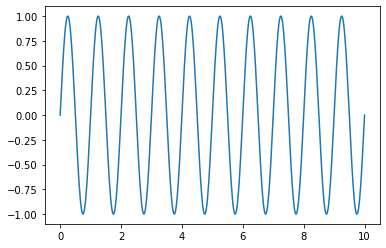

In [7]:
plt.plot(t,X_ini)

This is our data. Now let's take 10% of it as a 

In [34]:
# Test percentage and index
test_data_percentage = 0.1
test_data_idx = len(X_ini)-int(len(X_ini)*test_data_percentage)

# Train-test split
X_train_ini = X_ini[:test_data_idx]
X_test_ini = X_ini[test_data_idx:]

In [9]:
X_test_ini.shape

(50,)

In [9]:
# Inst. scaler
ts_scaler = MinMaxScaler()

# Fit scaler on training data
ts_scaler.fit(X_train_ini.reshape(-1,1))

# Scale train and test data
X_train = ts_scaler.transform(X_train_ini.reshape(-1,1))[:,0]
X_test = ts_scaler.transform(X_test_ini.reshape(-1,1))[:,0]

#### 2.a.2 - Dataset class

We implement a TimeSeries() class inherited from torch.utils.

In [12]:
# Version 2
class TimeSeries(Dataset):
    
    '''
        torch.utils.data.Dataset() subclass for encoding time series
        as states systems. Given a time_series (np.array()) of shape
        (n_time_stamps, n_channels) and a number of time lags n_x_lags, 
        an instance of TimeSeries() re-organizes the data as tensors (X,y),
        where:
        * y is the tensor of "outputs" of the series, of shape (1, n_channels);
        * X is the tensor of "inputs" of the series, of shape (n_x_lags, n_channels),
        
        Attributes:
        * n_x_lags: No. of time lags in input data (int).
        * n_channels: No. of channels in time series.
        * n_out_samples: No. of output samples = len(y) = len(time_series)-n_x_lags
        * X : Input data, dtype=Double, shape = (n_out_samples, n_x_lags, n_channels) (torch.tensor).
        * y : Output data, dtype=Double, shape = (n_out_samples, n_channels) (torch.tensor).
        
        Constructor args:
        * n_x_lags: Number of lags (int)
        * time_series: The original time series (np.array) of shape (N, n_channels).
        
        Example: 
    '''
    
    def __init__(self, time_series, n_x_lags):
        # Number of lags in the input
        self.n_x_lags = n_x_lags
        
        # No. of channels in time series
        self.n_channels = time_series.shape[1]
        
        # No. of output samples
        self.n_out_samples = time_series.shape[0]-n_x_lags
        
        # Output time series (specify Double)
        self.y = T.tensor(time_series[n_x_lags :,:], dtype = T.float64) 
        
        # Inputs (specify Double)
        self.X = T.empty(size = (len(self.y), self.n_x_lags, self.n_channels),\
                         dtype = T.float64) 
        
        for i in range(len(self.y)):
            self.X[i,:,:] = T.tensor(time_series[i:i+n_x_lags,:])

        
    def __len__(self):
        # For number of OUTPUT samples
        return self.n_out_samples
    
    def __getitem__(self,idx):
        # For indexing
        return (self.X[idx,:,:], self.y[idx,:])
    

___________________________________________________________________

### 2.b - Model construction



My first use of the Elman RNN was incorrect. The *input_size* argument is supposed to be the number of channels/features of the input sequence, and not the length of the input sequences, which I did in the first implementation. In Keras too, the length of the sequence isn't a parameter. 

In [14]:
# Version 5
class sRNN(Module):
    '''
            Note:
            Read documentation of torch.nn.RNN() carefully for 
            the input/output shapes and contents.
            https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
            Output of sRNN is computed as linear transformation of 
            the output of the last RNN unit.
            
            Agruments:
            * input_size: No. of channels in the input sequences (int)
            * hidden_size: No. of units in the hidden state (int)
            * nonlinearity: Nonlinearity to apply as activation
                            of RNN unit(string)
            * num_layers: No. of Elman RNN units to stack(int, default = 1).
            * output_size: Size of the output y_t (int, default =1).
    '''

    # Constructor
    def __init__(self, input_size, hidden_size,\
                 num_layers=1, nonlinearity="tanh", output_size=1):
        
        # What is this for?
        super().__init__()
        
        # Hyperparams
        self.input_size = input_size # No. of input channels (NOT length)
        self.hidden_size = hidden_size # No. of components of hidden state
        self.num_layers = num_layers # No. of RNN units
        self.nonlinearity = nonlinearity # Activation of RNN unit
        self.output_size = output_size # No. of output channels
        
        
        # Layers
        self.rnn_layer = RNN(input_size = self.input_size, hidden_size = self.hidden_size,\
                            num_layers = self.num_layers,nonlinearity = self.nonlinearity)
        
        self.out_layer = nn.Linear(in_features = self.hidden_size, out_features = self.output_size)
    
    # Forward pass
    def forward(self, X, h):
        
        X_out, h = self.rnn_layer(X, h)
        y = self.out_layer(X_out)
        return y, h.detach()

In [135]:
# Hyperparams:
n_in_channels = 1
n_x_lags = 100
n_out_channels = 1
# Change this later to see whats happens
hidden_size = 25

________________________________________________________

### 2.c - Training and validation

I initially used the TimeSeries() subclass of Dataset() with a DataLoader(), but this isn't really needed here.

In [14]:
# Dataset
D_ts = TimeSeries(time_series = X_train.reshape(-1,1), n_x_lags = 50)

# Loader
RNN_loader = DataLoader(dataset = D_ts, batch_size = 1, shuffle = False)

### Training

This training algorithm is my 5th attempt at this exercise. Here are some notes on what the training does, how I used 3 different optimizers, and some variations on other hyperparameters:
* The hidden state should be passed as an argument.
* In the class definition of the RNN, I detach the hidden state from the computational graph with *h.detach()*, otherwise I get an error message in the training.
* The output *Y_hat* of the forward pass is of dimension *(n_x_lags, n_in_channels)*. However, the error is computed on the very last component *Y_hat[-1]*.
* I tried SGD, RMSprop and ADAM for the optimizers, along with various learning rates, and 10 hidden state units as an initial try. SGD converges too slowly: It looks like I will need about 100 epochs before the loss is below 0.001. However, with 20 or 50 epochs, the validation results are nearly linear. 
* ADAM gave some better results with a learning rate of 0.001 and 20 epochs instead of 50. Higher learn rates gave bad convergence. The validation gave periodic data in this case, but there were too many periods.
* RMSprop gave a result that is slightly better than ADAM with 20 epochs. The validation forecasts were indeed periodic, but the amplitude was decaying. The result was slightly better when I took 40 epochs, then worse with 80 epochs. I changed the number of hidden units from 10 to 5 then 25, which solved the number of periods, but not the decay issue.
* Continuing with RMSprop, taking 50 hidden units and 50 epochs gave the same behavior as SGD, meaning those near constant forecasts. The results were slightly better with 20 hidden state units and 50 epochs, but still very bad.

In [ ]:
del sRNN_model, sRNN_loss_fn, optimizer

In [40]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
n_x_lags = 100
hidden_size = 10
num_layers=1
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
sRNN_model = sRNN(input_size = n_in_channels, hidden_size=hidden_size, \
                  num_layers = num_layers, nonlinearity='tanh', output_size=n_out_channels)

# Loss function:
sRNN_loss_fn = nn.MSELoss()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001) # Erratic
#optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.01) # Gives better training than ADAM
optimizer = T.optim.RMSprop(params = sRNN_model.parameters(), lr = 0.001) # THIS ONE GIVES BEST RESULTS

In [41]:
###########################################
##### TRAINING ON Y_i[-1] OF LENGTH 1 #####
###########################################


# Initializations
'''
    INSTANTIATE THE MODEL FIRST!
    This cell requires:
    n_in_channels =1
    n_x_lags = 50
    n_out_channels =1
'''
n_epochs = 20
batch_size = 1
# The following could be viewed as our batches
n_y_samples = len(X_train)-n_x_lags

# Timer init.
train_begin_time = datetime.now()
# Output vector loss history (many-to-many loss)
loss_hist = np.empty(shape = n_epochs)
# Effective loss (many-to-one loss)
effective_loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    #delta_y = np.empty(shape = n_y_samples)
    hidden_state = None
    epoch_losses = np.empty(shape = n_y_samples)
    epoch_eff_losses = np.empty(shape = n_y_samples)
    
    # Loop over samples/batches
    for i in range(n_y_samples):
        
        # Set up inputs and outputs of the state system
        X_i = T.tensor(X_train[i:i+n_x_lags], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        Y_i = T.tensor(X_train[i+1:i+n_x_lags+1], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = sRNN_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = sRNN_loss_fn(Y_hat_i[-1], Y_i[-1])# Gives warning about computation errors without the .double()
        epoch_losses[i] = T.sqrt(T.sum((Y_hat_i-Y_i).view(n_x_lags)**2)).item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = loss.item() # Delta of y
        
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
    # END OF BATCH LOOP
    
    # Losses
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.mean(epoch_eff_losses) # RMSE of the delta_y_i's
    
    # Verbose
    print(f"Epoch: {epoch+1}; Vector loss: {loss_hist[epoch]}; Effective loss: {effective_loss_hist[epoch]}")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

Epoch: 1; Vector loss: 2.631194244083176; Effective loss: 0.0466709130333918
Epoch: 2; Vector loss: 1.4940639251996988; Effective loss: 0.005955217517902982
Epoch: 3; Vector loss: 1.0226538482724432; Effective loss: 0.0007106757687334153
Epoch: 4; Vector loss: 0.9067321114900105; Effective loss: 0.0003770807735449387
Epoch: 5; Vector loss: 0.34369513040084787; Effective loss: 0.00020930581560003173
Epoch: 6; Vector loss: 0.5906794991588321; Effective loss: 0.00019875394899619936
Epoch: 7; Vector loss: 1.4038396289205959; Effective loss: 0.0008270286146009999
Epoch: 8; Vector loss: 0.42238053271913123; Effective loss: 0.00023295976089739398
Epoch: 9; Vector loss: 0.40022498560257447; Effective loss: 0.00014972999223213294
Epoch: 10; Vector loss: 0.31478293482055014; Effective loss: 0.00020176541038033165
Epoch: 11; Vector loss: 0.2965379603567966; Effective loss: 0.00016397175420450878
Epoch: 12; Vector loss: 0.3061009269324463; Effective loss: 0.00015539131606921082
Epoch: 13; Vector l

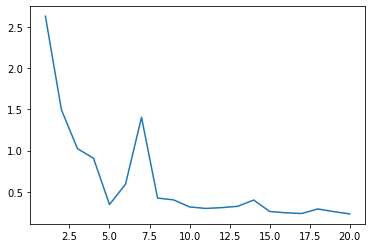

In [42]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

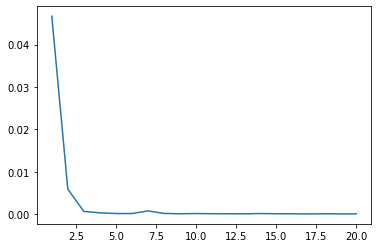

In [43]:
plt.plot(np.arange(1,n_epochs+1), effective_loss_hist)

**Quick test:** Check forecast of 1st point in test data.

In [44]:
z,h=sRNN_model(T.tensor(X_train[-100:], dtype=T.float32).reshape(n_x_lags,1), None)

In [45]:
z[-1]

tensor([0.5642], grad_fn=<SelectBackward0>)

In [46]:
X_test[0]

0.5627905195293119

________________________________________

### Validation


In [47]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

# Ini. validation forecast tensor
Y_hat = T.empty(size = (len(X_test),n_x_lags, n_in_channels))
y_hat = T.empty(size = (len(X_test),))
    
# Init. hidden state
hidden_state = None

# Get input tensor for i=0
i=0
input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float32)
    
# Compute forecast y_hat[0]
Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
y_hat[i] = Y_hat[i,-1,0]
#print(f"y_hat[{i}] = {y_hat[i].item()}")
    
    
# Compute next len(X_train)-1 forecasts
for i in range(1, len(X_test)):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = y_hat[i-1]

    # Compute forecast y_hat[i]
    Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    y_hat[i] = Y_hat[i,-1,0]
    #print(f"y_hat[{i}] = {y_hat[i].item()}")

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [48]:
# Re-Scaled Y_hat
#scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]
scY_hat = ts_scaler.inverse_transform(y_hat.numpy().reshape(1,-1))[0,:]

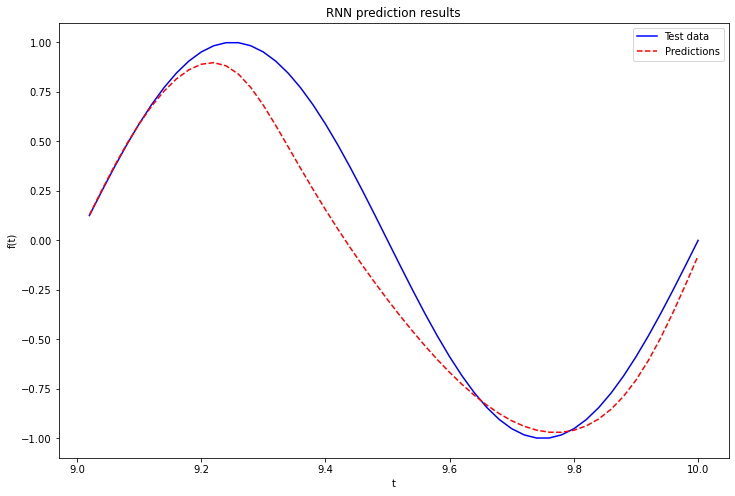

In [49]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_ini,'b', label='Test data')
plt.plot(s,scY_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

In [50]:
T.save(sRNN_model, "Torch_sRNN_220724_2130")

___________________________________________________________________

### 2.d - Out of sample forecasting

Let's forecast the next 50 points after the test data. We'll keep the same model, without retraining over the entire dataset (as an initial try).

In [51]:
len(X_test)

50

In [56]:
# Forecast horizon
n_fhor = 50
    
# Ini. validation forecast tensor
Z_hat = T.empty(size = (n_fhor,n_x_lags, n_in_channels))
z_hat = T.empty(size = (n_fhor,))

# Get input tensor for i=0
i=0
input_data_i = T.tensor(np.concatenate([X_train[-50:],X_test], axis = 0), dtype = T.float32)
    

# Compute Y_hat[0]
hidden_state = None
# Compute forecast z_hat[0]
Z_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
z_hat[i] = Z_hat[i,-1,0]
    
# Compute next len(X_train)-1 forecasts
for i in range(1, n_fhor):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = z_hat[i-1]

    # Compute forecast
    # Compute forecast z_hat[0]
    Z_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    z_hat[i] = Z_hat[i,-1,0]

In [62]:
# Re-Scaled Y_hat
scZ_hat = ts_scaler.inverse_transform(z_hat.numpy().reshape(1,-1))[0,:]

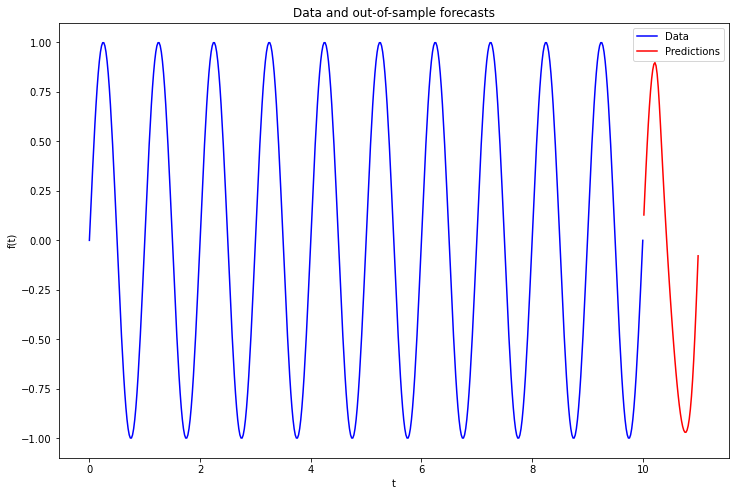

In [63]:
# Plot original dataset and forecasts
plt.figure(figsize = (12,8))
plt.xlabel('t')
plt.ylabel('f(t)')

plt.plot(t,X_ini,'b', label='Data')

# 
t_f = np.arange(start = t[-1]+0.02, stop = t[-1]+0.02*(n_fhor+1), step = 0.02)
plt.plot(t_f,scZ_hat,'r', label='Predictions')

plt.title('Data and out-of-sample forecasts')
plt.legend()
plt.show()

___________________________________________________________________

## 3) LSTMS and GRUs

We're redoing the previous example with these two architectures. For simplicity, no DataLoader() and no rescaling with sklearn.

___________________________________________________________________

### 3.A - Long Short Term Memory

#### Model class


**Add notes here**

In [29]:
# Version 5
class tLSTM(Module):
    '''
            Note:
            Read documentation of torch.nn.RNN() carefully for 
            the input/output shapes and contents.
            https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
            Output of sRNN is computed as linear transformation of 
            the output of the last RNN unit.
            
            Agruments:
            * input_size: No. of channels in the input sequences (int)
            * hidden_size: No. of units in the hidden state (int)
            * nonlinearity: Nonlinearity to apply as activation
                            of RNN unit(string)
            * num_layers: No. of Elman RNN units to stack(int, default = 1).
            * output_size: Size of the output y_t (int, default =1).
    '''

    # Constructor
    def __init__(self, input_size, hidden_size,\
                 num_layers=1, nonlinearity="tanh", output_size=1):
        
        # What is this for?
        super().__init__()
        
        # Hyperparams
        self.input_size = input_size # No. of input channels (NOT length)
        self.hidden_size = hidden_size # No. of components of hidden state
        self.num_layers = num_layers # No. of LSTM cells
        self.output_size = output_size # No. of output channels
        
        
        # Layers
        self.rnn_layer = LSTM(input_size = self.input_size, hidden_size = self.hidden_size,\
                            num_layers = self.num_layers)
        
        self.out_layer = nn.Linear(in_features = self.hidden_size, out_features = self.output_size)
    
    # Forward pass
    def forward(self, X, h, c):
        
        X_out, (h, c) = self.rnn_layer(X, (h,c))
        y = self.out_layer(X_out)
        return y, (h.detach(), c.detach())

In [9]:
test_LSTM = LSTM(input_size =1, hidden_size =10)

In [10]:
A = np.random.normal(size = 50)

In [17]:
A.shape

(50,)

In [26]:
h_test = T.zeros(size = (1,10))
c_test = T.zeros(size = (1,10))

In [25]:
h_test.shape

torch.Size([1, 10])

In [15]:
A_ = T.tensor(A, dtype = T.float32).view(50,1)

In [18]:
A_.shape

torch.Size([50, 1])

In [27]:
B, (h_test, c_test) = test_LSTM(A_)

In [23]:
h_test

tensor([[-0.2312, -0.0008,  0.0169, -0.0779, -0.0026,  0.1674, -0.1114,  0.1857,
         -0.0710,  0.0136]], grad_fn=<SqueezeBackward1>)

In [28]:
B.shape

torch.Size([50, 10])

________________________________________________________

#### Training (LSTM)

In [ ]:
del tLSTM_model, tLSTM_loss_fn, optimizer

In [31]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
n_x_lags = 100
n_hidden = 10
num_layers=1
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
tLSTM_model = tLSTM(input_size = n_in_channels, hidden_size=n_hidden, \
                  num_layers = num_layers, output_size=n_out_channels)

# Loss function:
tLSTM_loss_fn = nn.MSELoss()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001) # Erratic
#optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.01) # Gives better training than ADAM
optimizer = T.optim.RMSprop(params = tLSTM_model.parameters(), lr = 0.001) # THIS ONE GIVES BEST RESULTS

In [36]:

# Data (No scaling, no use of DataLoader)
X_train = X_train_ini
X_test = X_test_ini


In [37]:
###########################################
##### TRAINING ON Y_i[-1] OF LENGTH 1 #####
###########################################


# Initializations
'''
    INSTANTIATE THE MODEL FIRST!
    This cell requires:
    n_in_channels =1
    n_x_lags = 50
    n_out_channels =1
'''
n_epochs = 10
batch_size = 1
# The following could be viewed as our batches
n_y_samples = len(X_train)-n_x_lags

# Timer init.
train_begin_time = datetime.now()
# Output vector loss history (many-to-many loss)
loss_hist = np.empty(shape = n_epochs)
# Effective loss (many-to-one loss)
effective_loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    #delta_y = np.empty(shape = n_y_samples)
    h_i = T.zeros(size = (n_in_channels, n_hidden))
    c_i = T.zeros(size = (n_in_channels, n_hidden))
    epoch_losses = np.empty(shape = n_y_samples)
    epoch_eff_losses = np.empty(shape = n_y_samples)
    
    # Loop over samples/batches
    for i in range(n_y_samples):
        
        # Set up inputs and outputs of the state system
        X_i = T.tensor(X_train[i:i+n_x_lags], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        Y_i = T.tensor(X_train[i+1:i+n_x_lags+1], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        
        
        ## MANY-TO-ONE
        # Predict Y_hat_i 
        Y_hat_i, (h_i, c_i) = tLSTM_model(X_i, h_i, c_i)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-one loss
        loss = tLSTM_loss_fn(Y_hat_i[-1], Y_i[-1])
        epoch_losses[i] = T.sqrt(T.sum((Y_hat_i-Y_i).view(n_x_lags)**2)).item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = loss.item() # Delta of y
        
        
        '''
        ## MANY-TO-MANY
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = tLSTM_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = tLSTM_loss_fn(Y_hat_i, Y_i)# Gives warning about computation errors without the .double()
        epoch_losses[i] = loss.item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = Y_hat_i[-1]-Y_i[-1]
        '''
        
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
    # END OF BATCH LOOP
    
    # Losses
    
    ## MANY-TO-ONE
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.mean(epoch_eff_losses) # RMSE of the delta_y_i's
    
    '''
    ## MANY-TO-MANY
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.sqrt(np.mean(epoch_eff_losses**2)) # RMSE of the delta_y_i's
    '''
    
    # Verbose
    print(f"Epoch: {epoch+1}; Vector loss: {loss_hist[epoch]}; Effective loss: {effective_loss_hist[epoch]}")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

Epoch: 1; Vector loss: 4.3074918683098256; Effective loss: 0.1662158471999154
Epoch: 2; Vector loss: 1.357682500045184; Effective loss: 0.016316444829161978
Epoch: 3; Vector loss: 0.31491958237441514; Effective loss: 0.00019822225027061734
Epoch: 4; Vector loss: 0.2932683132652544; Effective loss: 0.00029002090564181734
Epoch: 5; Vector loss: 0.2731621905609413; Effective loss: 0.00029294397924640027
Epoch: 6; Vector loss: 0.26577589692723036; Effective loss: 0.0002833453322968985
Epoch: 7; Vector loss: 0.26051211909011557; Effective loss: 0.00029550579658361607
Epoch: 8; Vector loss: 0.2802739327619558; Effective loss: 0.0002748099424797336
Epoch: 9; Vector loss: 0.29206477109862866; Effective loss: 0.00031369702672430044
Epoch: 10; Vector loss: 0.2897014184045656; Effective loss: 0.00023023417847979087
Training finished. Elapsed time = 0:01:09.380464


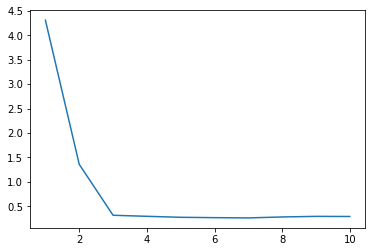

In [38]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

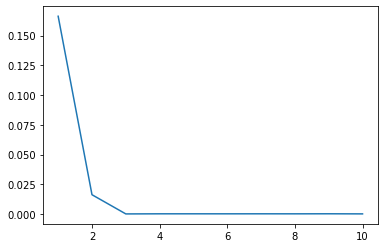

In [39]:
plt.plot(np.arange(1,n_epochs+1), effective_loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

In [45]:
h = T.zeros(size = (n_in_channels, n_hidden))
c = h
z,(h, c)=tLSTM_model(T.tensor(X_train[-100:], dtype=T.float32).reshape(n_x_lags,1), h, c)

In [46]:
z.shape

torch.Size([100, 1])

In [47]:
z[-1]

tensor([0.1326], grad_fn=<SelectBackward0>)

In [49]:
X_test[0]

0.12533323356430134

##### Validation


In [ ]:
X_test.shape

In [52]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

# Ini. validation forecast tensor
Y_hat = T.empty(size = (len(X_test),n_x_lags, n_in_channels))
y_hat = T.empty(size = (len(X_test),))
#H = T.empty(size=(len(X_test),n_hidden))
    

# Get input tensor for i=0
i=0
input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float32)
    

# MANY-TO-ONE
# Compute forecast y_hat[0]
Y_hat[i,:,:], (h, c) = tLSTM_model(input_data_i.reshape(n_x_lags,n_in_channels), h_i, c_i)
y_hat[i] = Y_hat[i,-1,0]
#H[i,:] = hidden_state[0,:]
    
# Compute next len(X_train)-1 forecasts
for i in range(1, len(X_test)):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = y_hat[i-1]

    # Compute forecast y_hat[i]
    Y_hat[i,:,:], (h,c) = tLSTM_model(input_data_i.reshape(n_x_lags,n_in_channels), h, c)
    y_hat[i] = Y_hat[i,-1,0]
    #H[i,:] = hidden_state[0,:]
    

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [53]:
# Re-Scaled Y_hat
#scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]
np_y_hat = y_hat.numpy()

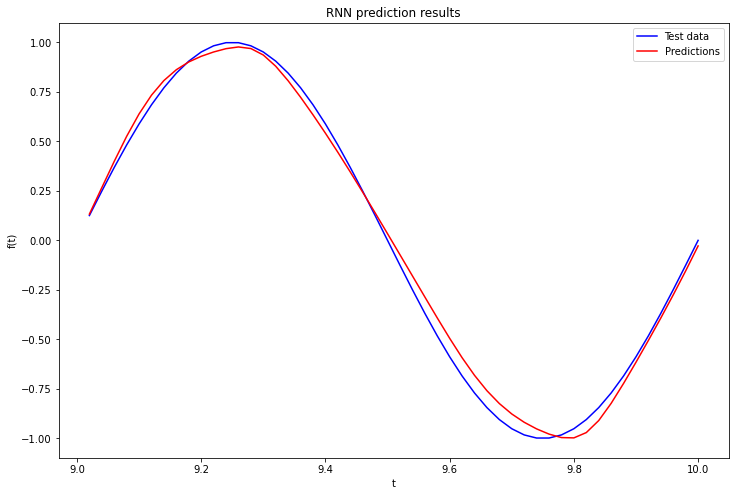

In [55]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test,'b', label='Test data')
plt.plot(s,np_y_hat,'r', label='Predictions')
#plt.plot(s,H[:,9].numpy(),'g--', label='Hidden state 9')
#plt.plot(s,H[:,8].numpy(),'k--', label='Hidden state 8')
#plt.plot(s,H[:,2].numpy(),'m--', label='Hidden state 2')
#plt.plot(s,H[:,3].numpy(),'brown', label='Hidden state 3')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

In [ ]:
hidden_state[0,:].shape

____________________________________________________________________________________________________________________